### Frame the problem

Spam is annoying and costs users time. Less spam will improve user experience.

If this were a real spam filter, it would be used to prevent spam from going into a user's inbox. There would likely be a separate folder for spam mail so the user could check for mislabled messages if desired.

Spam filtering is a supervised problem. For the purposes of this project it will be offline.

Performance will be measured by precision and coverage. The dataset contains about 30% spam, 70% ham, and so it would not be appropriate to use accuracy. Precision is more important than recall (when spam is the positive class). 

I'm not sure what is possible yet, so to choose something arbitrary, I'll shoot for 98% precision with 90% coverage.



In [25]:
import chardet
from email import message_from_string
import re
from os import listdir, getcwd
from os.path import isfile, join

import pandas as pd
import numpy as np

from nltk import Text, wordpunct_tokenize
from nltk.stem import LancasterStemmer

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                                recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
spam_dirs = ["spam/spam", "spam/spam_2"]
ham_dirs = ["spam/easy_ham", "spam/easy_ham 2", "spam/hard_ham"]
pwd = getcwd()

def read_directories(directories):
    for d in directories:
        for f in listdir(d):
            if isfile(join(d, f)) and "." in f:
                yield join(d, f)
                
def read_file(path):
    with open(path, 'rb') as f:
        contents = f.read()
    return contents

def read_and_decode(paths):
    raw = []
    for path in paths:
        contents = read_file(path)
        encoding = chardet.detect(contents)["encoding"]
        try:
            decoded = contents.decode(encoding)
        except UnicodeDecodeError:
            print(f"failed to decode spam file {path}")
            continue
        raw.append(decoded)
    return raw
    
    
def load_dataset():
    spam_files = read_directories(join(pwd, d) for d in spam_dirs)
    ham_files = read_directories(join(pwd, d) for d in ham_dirs)
    
    spam_raw = read_and_decode(spam_files)
    ham_raw = read_and_decode(ham_files)
        
    return pd.DataFrame({
        "RawEmails": spam_raw + ham_raw,
        "Class": [1] * len(spam_raw) + [0] * len(ham_raw)
    })
    

original_dataset = load_dataset()

failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0369.2530542de47d461ccb925fcafc6f0ad5
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0304.88cf1d3ce0e138fd9ffb801e675f69b3
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0290.13035c75be0d5b447a10e2263f8c1361
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0100.c60d1c697136b07c947fa180ba3e0441
failed to decode spam file /Users/jon/src/handson-projects/spam/spam/0123.68e87f8b736959b1ab5c4b5f2ce7484a
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/00475.3d497c7d96c51986316db566756ff35a
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01227.04a4f94c7a73b29cb56bf38c7d526116
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01065.9ecef01b01ca912fa35453196b4dae4c
failed to decode spam file /Users/jon/src/handson-projects/spam/spam_2/01376.73e738e4cd8121ce3dfb42d190b193c9
failed to decode spam fil

In [3]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   RawEmails  7189 non-null   object
 1   Class      7189 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.5+ KB


In [4]:
original_dataset["Class"].value_counts()

0    5301
1    1888
Name: Class, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(original_dataset["RawEmails"], original_dataset["Class"])

In [17]:
def remove_headers(text):
    msg = message_from_string(text)
    payload = msg.get_payload()
    return " ".join(str(m) for m in payload) if isinstance(payload, list) else payload

def remove_html(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    return text
    

def remove_urls(text):
    return re.sub(r"http\S+", "URL", text)

vec_remove_headers = np.vectorize(remove_headers)
vec_remove_html = np.vectorize(remove_html)
vec_remove_urls = np.vectorize(remove_urls)


class RawEmailPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, remove_headers=True, remove_html=True, replace_urls=True, lowercase=True):
        self.remove_headers = remove_headers
        self.remove_html = remove_html
        self.replace_urls = replace_urls
        self.lowercase = lowercase
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.remove_headers:
            X = vec_remove_headers(X)
        
        if self.remove_html:
            X = vec_remove_html(X)
        
        if self.replace_urls:
            X = vec_remove_urls(X)
            
        if self.lowercase:
            X = np.char.lower(X)
        
        return X

In [29]:
class StemmedCountVectorizer(CountVectorizer):
    def __init__(self, stem=True, **kwargs):
        super().__init__(**kwargs)
        self.stem = stem
        self.stemmer = LancasterStemmer()
    
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        if not self.stem:
            return analyzer
        return lambda doc: ([self.stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words='french', stem=False)

In [35]:
preparation_pipeline = Pipeline([
    ("clean", RawEmailPreprocessor(lowercase=False, remove_headers=False, replace_urls=False)),
    ("vect", StemmedCountVectorizer()),
    ("tfidf", TfidfTransformer())
])

In [36]:
X_prepared = preparation_pipeline.fit_transform(X_train)

In [21]:
X_prepared.shape

(5391, 52323)

In [10]:
len(y_train[y_train == 1.])

1408

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


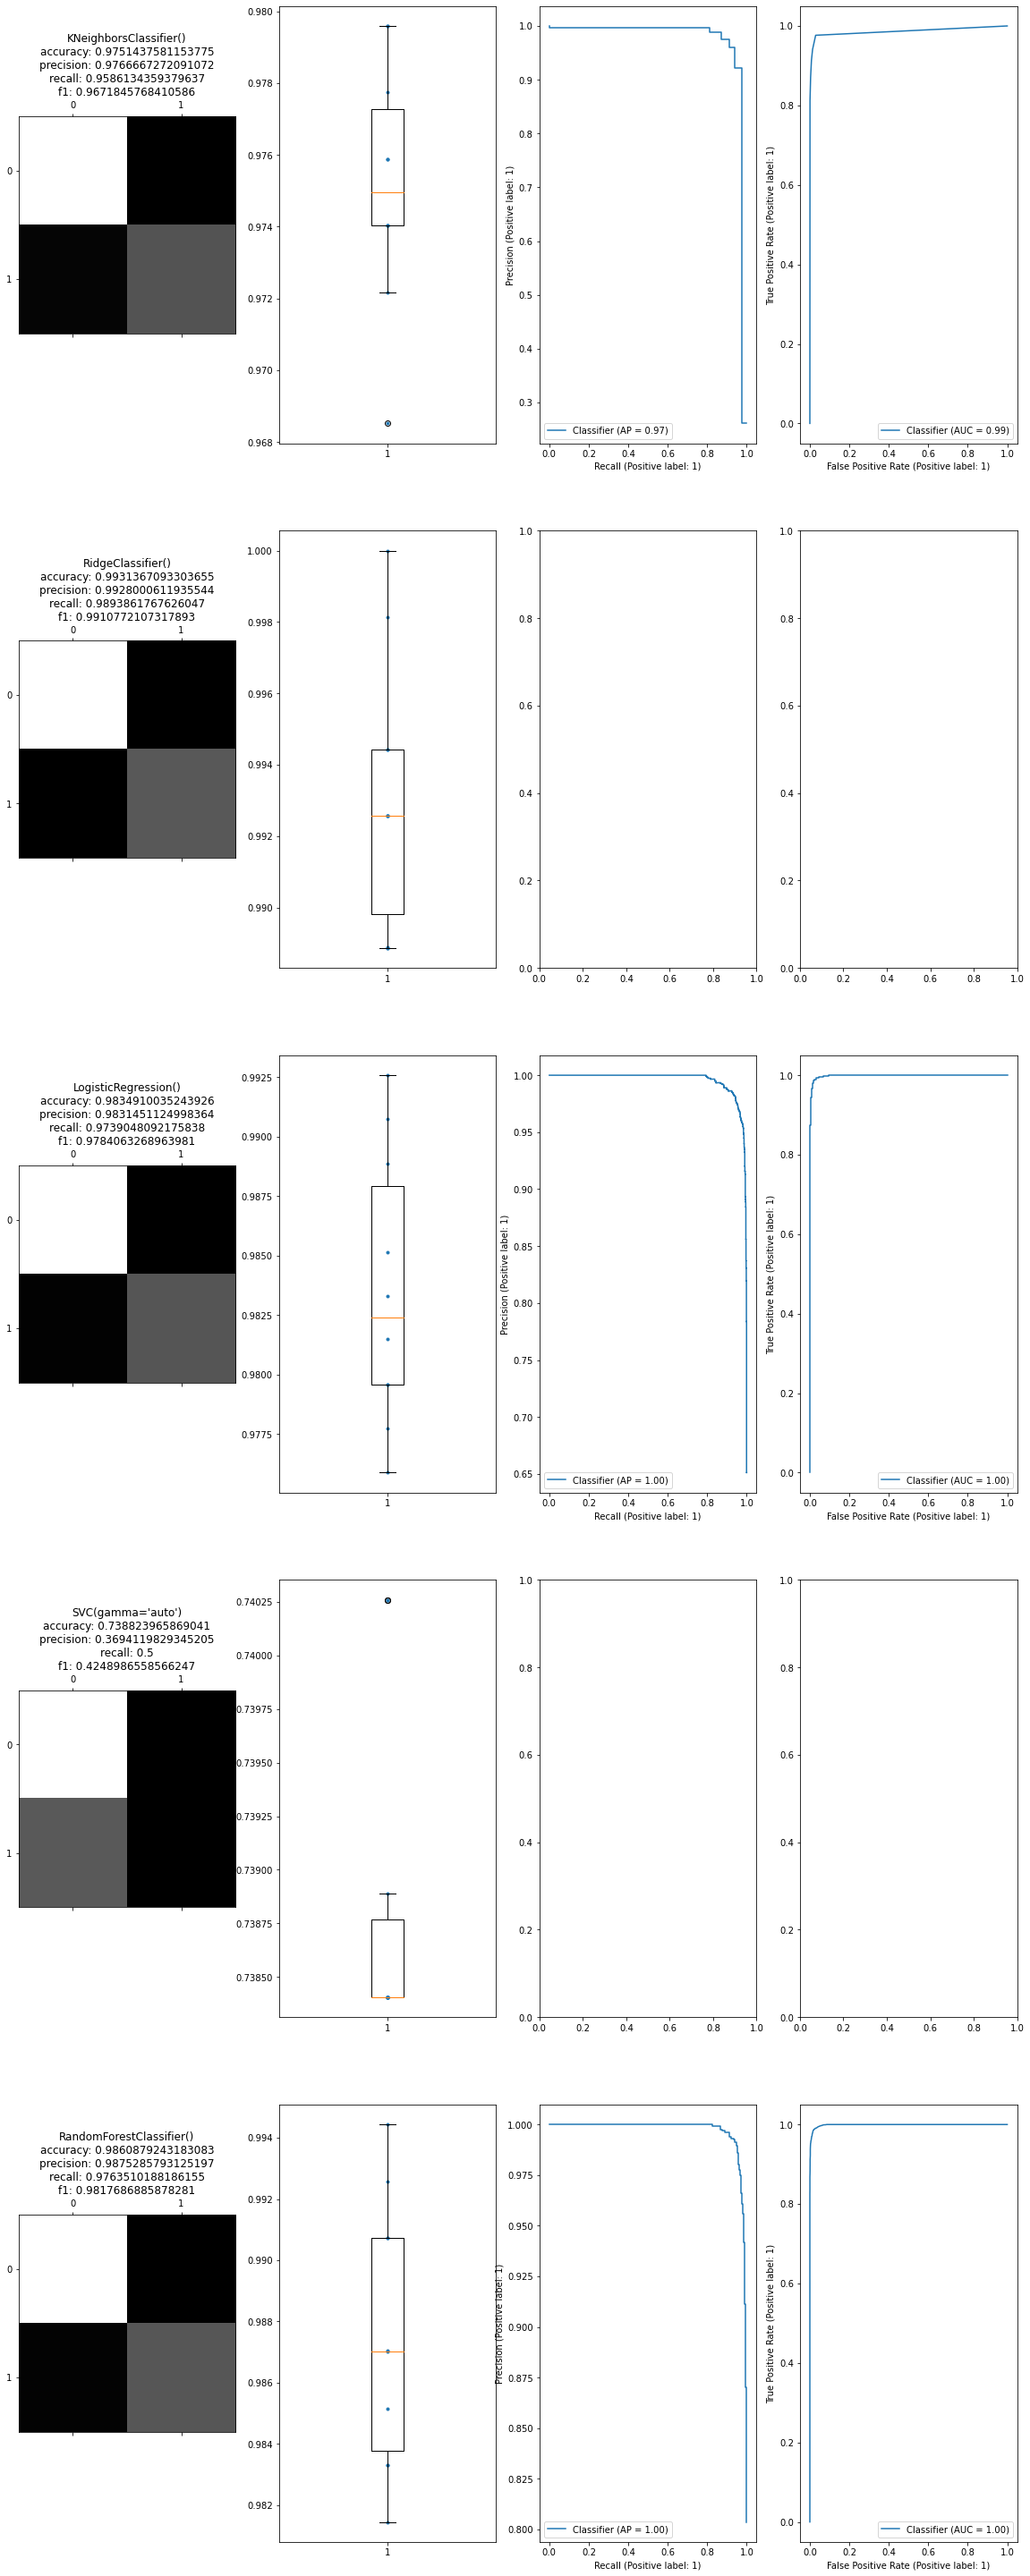

In [37]:
X_train_sample = X_prepared[:, :]
y_train_sample = y_train[:]

models = [
    KNeighborsClassifier(), 
    RidgeClassifier(),
    # GaussianNB(),
    LogisticRegression(),
    SVC(gamma="auto"), 
    RandomForestClassifier(), 
]

k_folds = 10

fig, axs = plt.subplots(len(models), 4, figsize=(20, 35))
plt.subplots_adjust(top=1.25)
for i, model in enumerate(models):
    y_train_pred = cross_val_predict(model, X_train_sample, y_train_sample, cv=k_folds)
    scores = cross_val_score(model, X_train_sample, y_train_sample, cv=k_folds)
    conf_mx = confusion_matrix(y_train_sample, y_train_pred)
    accuracy = accuracy_score(y_train_sample, y_train_pred)
    precision = precision_score(y_train_sample, y_train_pred, average="macro")
    recall = recall_score(y_train_sample, y_train_pred, average="macro")
    f1 = f1_score(y_train_sample, y_train_pred, average="macro")
    axs[i, 0].matshow(conf_mx, cmap=plt.cm.gray)
    axs[i, 0].set_title(f"{model}\naccuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1: {f1}")
   
    # cross validation scores boxplot
    axs[i, 1].plot([1]*k_folds, scores, ".")
    axs[i, 1].boxplot([scores])
    
    if hasattr(model, "predict_proba"):
        y_train_pred_proba = cross_val_predict(model, X_train_sample, y_train_sample, cv=3, method="predict_proba")
        PrecisionRecallDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 2])
        RocCurveDisplay.from_predictions(y_train_sample, y_train_pred_proba[:, 1], ax=axs[i, 3])
    
plt.show()

In [32]:
ridge_classifier_pipeline = Pipeline([
    ("preparation", preparation_pipeline),
    ("ridge_clf", RidgeClassifier()),
])

param_grid = {
   "preparation__clean__remove_headers": [False, True],
   "preparation__clean__remove_html": [False, True],
   "preparation__clean__replace_urls": [False, True],
   "preparation__clean__lowercase": [False, True],
   "preparation__vect__stem": [False, True],
   #"vect__max_df": (0.5, 0.75, 1.0),
   # 'vect__max_features': (None, 5000, 10000, 50000),
   #"vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
   # 'tfidf__use_idf': (True, False),
   # 'tfidf__norm': ('l1', 'l2'),
}

grid_search = GridSearchCV(
    ridge_classifier_pipeline, 
    param_grid,
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. Yo

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. Yo

	preparation__clean__lowercase: False
	preparation__clean__remove_headers: False
	preparation__clean__remove_html: True
	preparation__clean__replace_urls: False
	preparation__vect__stem: False
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=False; total time=   6.0s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=True, preparation__vect__stem=False; total time=  11.4s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=True, preparation__vect__stem=True; total time= 1.7min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=

[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=False; total time=   6.0s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=True; total time= 1.7min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=False, preparation__vect__stem=False; total time=  32.1s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=False, preparation__vect__stem=True; total time= 1.9min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=True, preparation__clean__remove_html=False, preparatio

[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=False; total time=   6.0s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=True; total time= 1.7min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=False, preparation__vect__stem=False; total time=  32.7s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=False, preparation__vect__stem=True; total time= 1.8min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparatio

[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=False, preparation__vect__stem=True; total time= 1.6min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=False, preparation__clean__replace_urls=True, preparation__vect__stem=True; total time= 1.8min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=True, preparation__vect__stem=False; total time=  33.1s
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=False, preparation__clean__remove_html=True, preparation__clean__replace_urls=True, preparation__vect__stem=True; total time= 1.8min
[CV] END preparation__clean__lowercase=False, preparation__clean__remove_headers=True, preparation__clean__remove_html=False, preparation__c

In [34]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.9929512827963775
Pipeline(steps=[('preparation',
                 Pipeline(steps=[('clean',
                                  RawEmailPreprocessor(lowercase=False,
                                                       remove_headers=False,
                                                       replace_urls=False)),
                                 ('vect', StemmedCountVectorizer(stem=False)),
                                 ('tfidf', TfidfTransformer())])),
                ('ridge_clf', RidgeClassifier())])
